## Adaptive Resonance Theory
Feedback mechanism + Competitive-learning scheme
#### ART2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.datasets import mnist
import numpy as np
import numpy.linalg as LA
import math
from tqdm import tqdm

Using Theano backend.


#### 讀取 MNIST
see https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

In [2]:
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
_, img_rows, img_cols = x_train.shape
print ('原始 shape = (資料數目, #row, #col)')
print ('#train = ', x_train.shape[0], ', #test = ', x_test.shape[0])
print ('image rows = ', img_rows, ', image_cols = ', img_cols)
# flatten
x_train = np.reshape(x_train, (x_train.shape[0], img_rows*img_cols))
x_test = np.reshape(x_test, (x_test.shape[0], img_rows*img_cols))
print ('image map 轉 vector')
print ('new x_train.shape = ', x_train.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

原始 shape = (資料數目, #row, #col)
#train =  60000 , #test =  10000
image rows =  28 , image_cols =  28
image map 轉 vector
new x_train.shape =  (60000, 784)


### ART2
* $dim(I) = dim(F_1)= M$
* $dim(F_2) = N$
* $0<d<1$
* $\mathbf{z}^I=(z_{1,I}, z_{2,I},...,z_{N,I})$ : Top-Down weights
* $\mathbf{z}^J$ : Bottom-Up weights

In [3]:
class ART2(object):
    def __init__(self, M=5, N=6, a=1.0, b=1.0, c=0.1, d=0.9, e=0.001, theta=0.1, rho=0.97):
        self.M = M # input dim = dim(F1) = M
        self.N = N # dim(F2) = N
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.e = e
        self.rho = rho
        self.theta = theta
        self.Zi = np.zeros((N,M)) ## Top-down weights
        self.Zj = np.random.uniform(low=0.0, high=1.0/((1-d)*math.sqrt(M)), size=(M,N)) ##  Bottom-Up weights
        self.commited = 0
        self.counter = 0
        self.time_stamps = np.zeros(N)
        
    def F(self, x):
        v = np.array(x)
        idx = x[:] <= self.theta
        v[ idx ] = np.divide(2.0 * self.theta * np.power(x[idx], 2), np.power(x[idx], 2) + (self.theta ** 2))
        return v
    
    def Gyj(self, T):
        result = np.zeros((self.commited))
        result[np.argmax(T)] = self.d
        return result
        

    def Processing(self, I):
        u = np.zeros_like(I)
        p = np.zeros_like(I)
        q = np.zeros_like(I)
        count = 0
        while True:
            count += 1
            last_p = np.array(p)
            w = I + self.a * u
            x = (1.0/(self.e + LA.norm(w))) * w
            v = self.F(x) + (self.b * self.F(q))
            u = (1.0/(self.e + LA.norm(v))) * v
            p = np.array(u)
            q = (1.0/(self.e + LA.norm(p))) * p
            if (LA.norm(last_p - p) == 0.0) or (count >= 100):
                break
                
        # Calculate the input to F2
        T = np.dot(self.Zj[:,:self.commited].transpose(), p)
        J = np.flipud(np.argsort(T))
        u_init = np.array(u)
        for winner in J:
            # Feedback F2 -> p
            dzj = self.d * self.Zi[winner,:]
            p = u_init + dzj
            q = (1.0/(self.e + LA.norm(p))) * p
            count = 0
            while True:
                count += 1
                last_q = np.array(q)
                w = I + self.a * u
                x = (1.0/(self.e + LA.norm(w))) * w
                v = self.F(x) + (self.b * self.F(q))
                u = (1.0/(self.e + LA.norm(v))) * v
                p = u + dzj
                q = (1.0/(self.e + LA.norm(p))) * p
                if (last_q == q).all() or (count >= 100):
                    break
            # Calculate r output
            r = np.zeros_like(p)
            r = (u+self.c*p) / (self.e + LA.norm(u) + LA.norm(self.c*p))
            if (self.rho/(self.e + LA.norm(r))) > 1:
                # reset
                continue
            else:
                # update
                # Modify BU weights on the winner
                self.Zj[:,winner] = u / (1.0-self.d)
                self.Zi[winner,:] = u / (1.0-self.d)
                self.counter += 1
                self.time_stamps[winner] = self.counter
                return winner
        # no match
        winner = -1
        if self.commited < self.N:
            winner = self.commited
            self.commited += 1
        else:
            winner = np.argmin(self.counter)
            
        self.Zj[:,winner] = u / (1.0-self.d)
        self.Zi[winner,:] = u / (1.0-self.d)
        self.counter += 1
        self.time_stamps[winner] = self.counter
        return winner
        

In [4]:
model = ART2(M = x_train.shape[1], N=100)
idx = np.arange(x_train.shape[0])
np.random.shuffle(idx)
for i in tqdm(range(x_train.shape[0] * 1)): #for i in tqdm(range(3000)):
    winner = model.Processing(x_train[idx[i%x_train.shape[0]],:])
    if winner == -1:
        print ('early stop')
        break

100%|██████████| 60000/60000 [08:30<00:00, 117.57it/s]


100


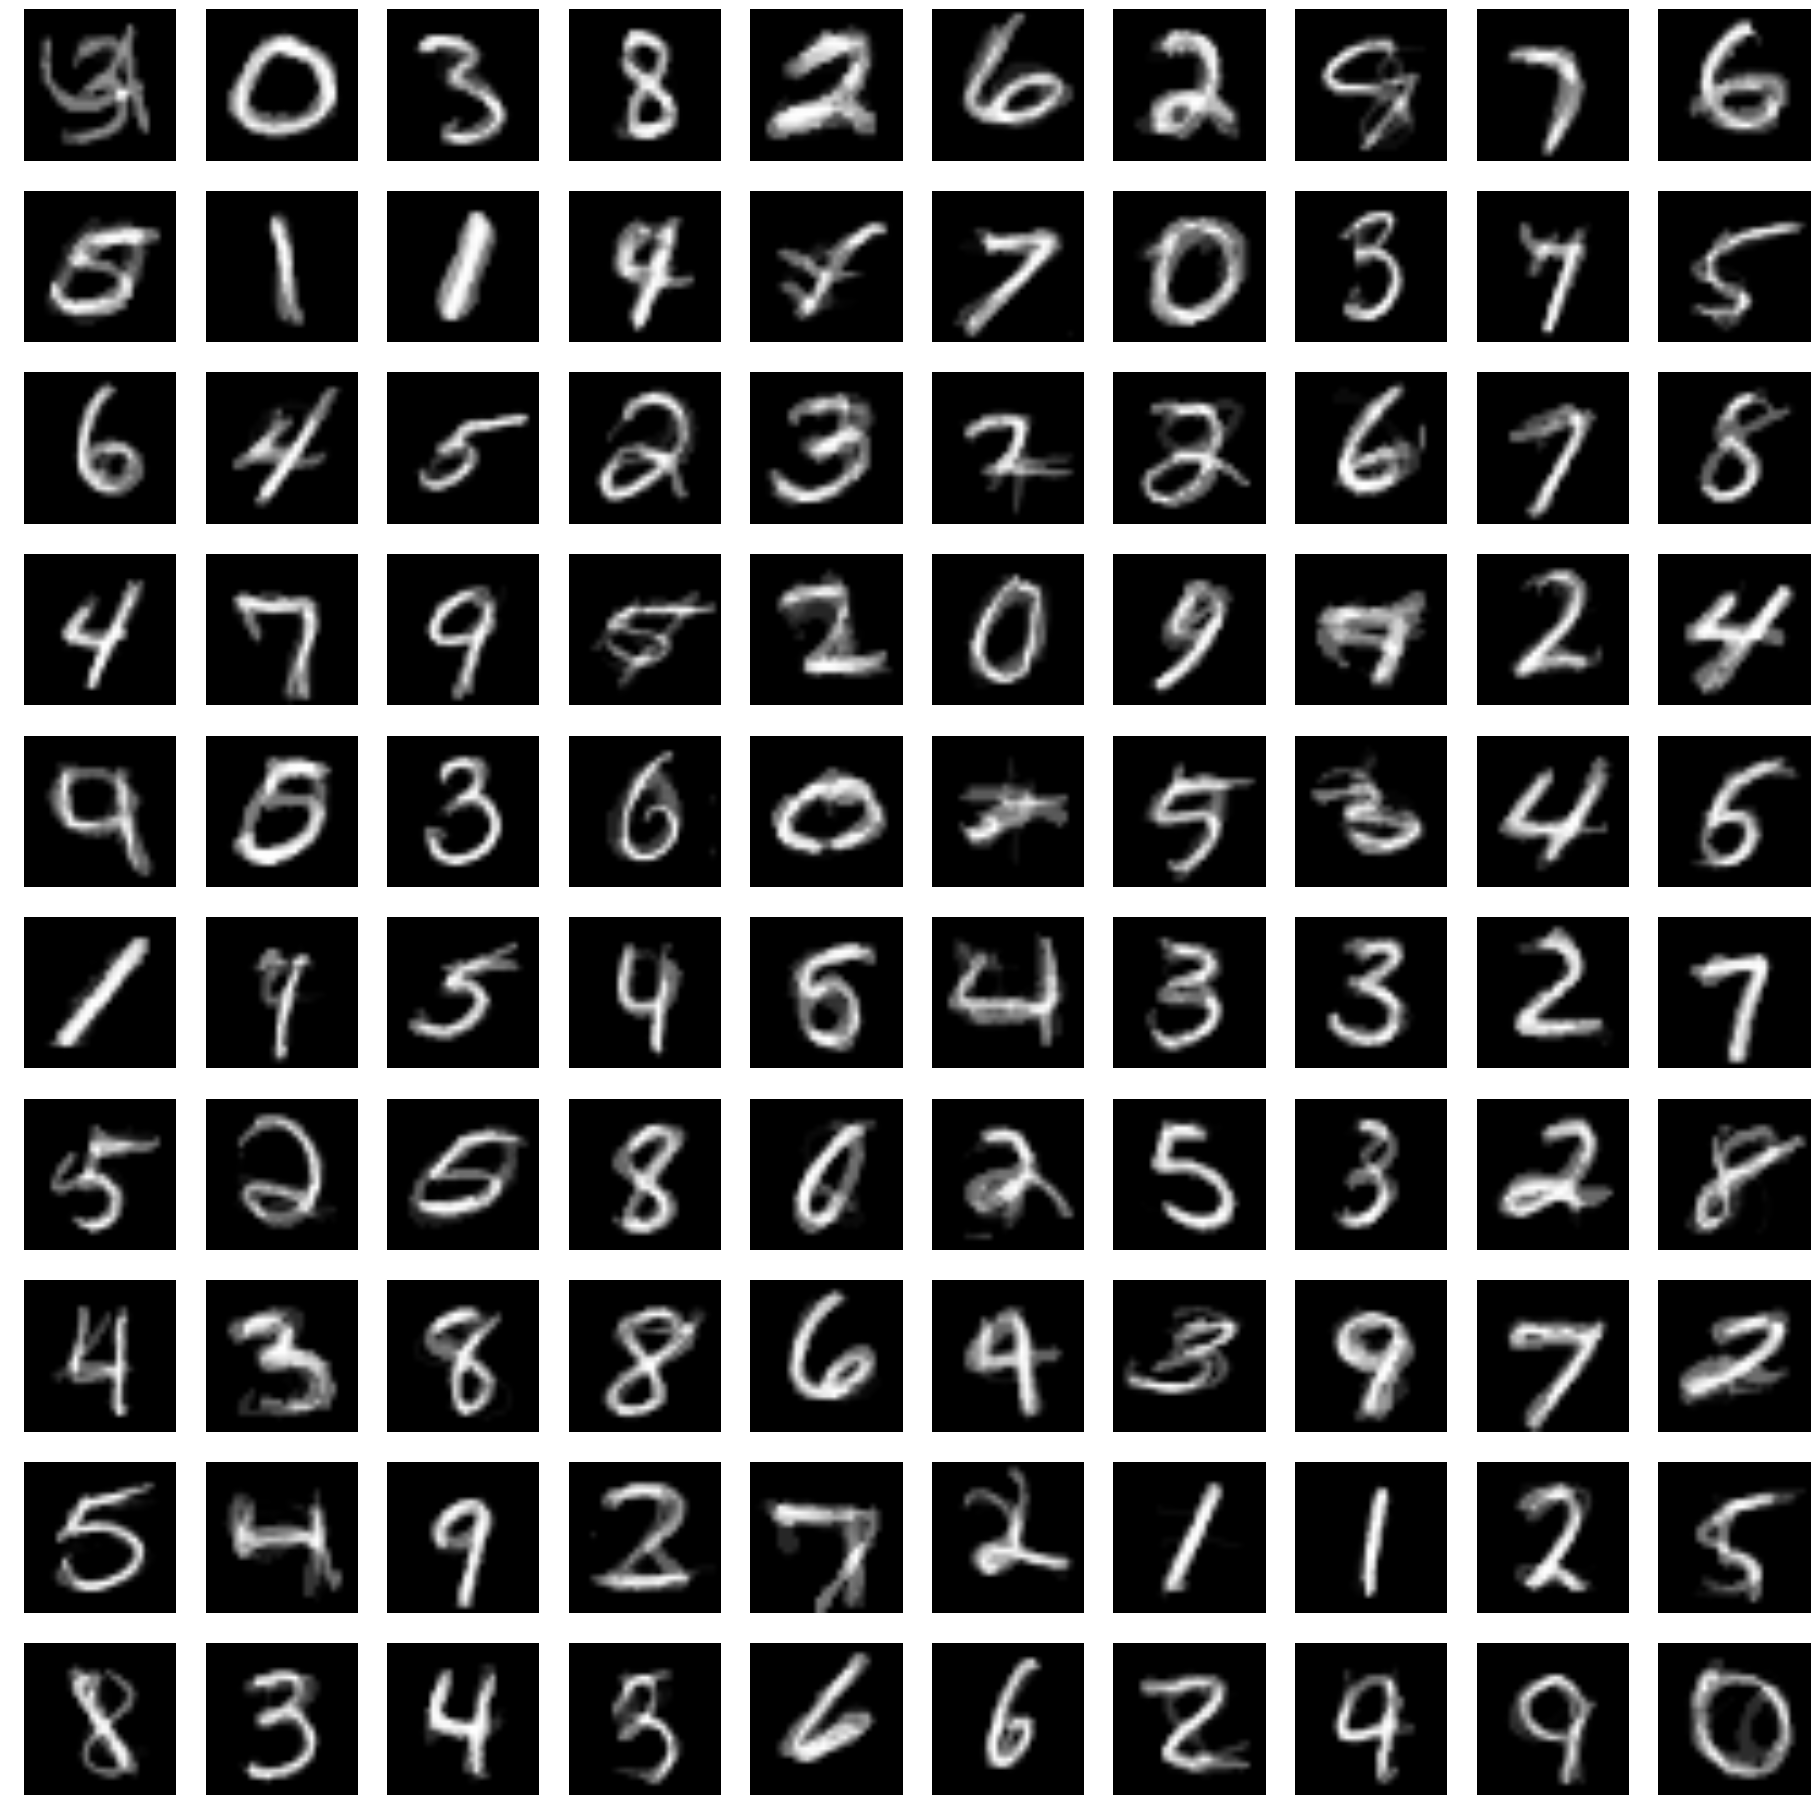

In [5]:
plt.figure(figsize=(32,32))
print (model.commited)
for i in range(model.commited):
    plt.subplot(10,10,1 + i)
    plt.axis('off')
    plt.imshow(np.reshape(model.Zi[i,:], (28,28)), cmap='gray')
